In [1]:
import tensorflow as tf
from tensorflow import keras
!pip install -U tensorflow-addons
import tensorflow_addons as tfa
!pip install -U efficientnet
import efficientnet.tfkeras as efn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import os
import shutil
import random

     |████████████████████████████████| 686kB 3.2MB/s 
     |████████████████████████████████| 51kB 1.7MB/s 


In [2]:
# Authentications when using on colab

IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is'
#  always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
    from google.colab import auth
    from google.colab import drive
    drive.mount('/content/drive')

    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/drive/MyDrive/Colab/brave-hearth-289814-20ac23157c25.json"
    # Authenticates the Colab machine and also the TPU using your
    # credentials so that they can access your private GCS buckets.
    auth.authenticate_user()

Mounted at /content/drive


In [ ]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

batch_size = 16 * REPLICAS
print(f'REPLICAS: {REPLICAS}')
print(f'Batch_size: {batch_size}')

Running on TPU grpc://10.102.36.202:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.102.36.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.36.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS: 8
Batch_size: 128


In [ ]:
class CONFIG():
    models_path = "/content/drive/MyDrive/Colab/Kaggle/PlantPathology2021/Models"
    gsc_path = ""

    classes = ['complex','frog_eye_leaf_spot','powdery_mildew', 
                'rust','scab','healthy']

    strategy = strategy
    batch_size = batch_size
    shuffle_buffer = 2048

    random_seed = 42
    input_img_size = 512
    img_size = 224
    cutout_mask_size = 2 * int((img_size*0.1)/2)
    folds = 5
    patience_EarlyStopping = 5
    patience_ReduceLR = 3
    reduceLR_factor = 0.1
    lr = 0.0005
    min_lr = 1e-8

    epochs = 150
    verbose = 1

In [ ]:
# Dataset Functions

def count_data_items(filenames):
    return np.sum([int(x[:-6].split('-')[-1]) for x in filenames])

feature_map = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'complex': tf.io.FixedLenFeature([], tf.int64),
    'frog_eye_leaf_spot': tf.io.FixedLenFeature([], tf.int64),
    'powdery_mildew': tf.io.FixedLenFeature([], tf.int64),
    'rust': tf.io.FixedLenFeature([], tf.int64),
    'scab': tf.io.FixedLenFeature([], tf.int64),
    'healthy': tf.io.FixedLenFeature([], tf.int64)}


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.image.resize(image, [CONFIG.img_size, CONFIG.img_size])
    image = tf.reshape(image, [CONFIG.img_size, CONFIG.img_size, 3])
    # image = tf.cast(image, tf.int32)
    image = tf.cast(image, tf.float32) / 255.
    return image


def read_tfrecord(example, labeled=True):
    example = tf.io.parse_single_example(example, feature_map)
    image = decode_image(example['image'])
    if labeled:
        label = [tf.cast(example[x], tf.float32) for x in CONFIG.classes]
    else:
        label = example['image_name']
    return image, label

def augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    image = tf.image.random_hue(image, .1)
    image = tf.image.random_saturation(image, .8, 1.2)
    image = tf.image.random_contrast(image, .8, 1.2)
    image = tf.image.random_brightness(image, .1)

    # rotation -15 to 15 deg counterclockwise
    k_rad = tf.random.uniform([CONFIG.batch_size], minval=-0.2618, maxval=0.2618, dtype=tf.dtypes.float32)
    image = tfa.image.rotate(image, k_rad)

    for _ in range(5):
        image = tfa.image.random_cutout(image, mask_size=CONFIG.cutout_mask_size)
    
    image = tf.clip_by_value(image, 0.0, 1.0)
    image = tf.reshape(image, [-1, CONFIG.img_size, CONFIG.img_size, 3])
    return image, label


def denormalize_pp(image, label):
    image = tf.cast(image*255, tf.float32)
    return image, label


def resnet_pp(image, label):
    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    return image, label


def get_dataset(filenames, labeled=True, augment=False, repeat=False, shuffle=False, cache=False, distribute=False, denormalize=False, resnet=False):
    """
    denormalize - use when using MobileNetV3 since model excepts image data in 0-255 range
    resnet - preprocessing for using ResNet50V2
    """
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.map(lambda x: read_tfrecord(x, labeled=labeled), 
                            num_parallel_calls=AUTO)

    if shuffle:
        dataset = dataset.shuffle(CONFIG.shuffle_buffer)

    dataset = dataset.batch(CONFIG.batch_size, drop_remainder=True)

    if augment:
        dataset = dataset.map(augmentation, num_parallel_calls=AUTO)
    if denormalize:
        dataset = dataset.map(denormalize_pp, num_parallel_calls=AUTO)
    if resnet:
        dataset = dataset.map(resnet_pp, num_parallel_calls=AUTO)

    if repeat:
        dataset = dataset.repeat()
    if cache:
        dataset = dataset.cache()

    dataset = dataset.prefetch(AUTO)

    if distribute:
        dataset = CONFIG.strategy.experimental_distribute_dataset(dataset)
    return dataset
    

def get_model_EN_B4():
    model = tf.keras.models.Sequential(name='EfficientNetB4-noisy-student')
    
    model.add(efn.EfficientNetB4(
        include_top=False,
        input_shape=(CONFIG.img_size, CONFIG.img_size, 3),
        weights='noisy-student',
        pooling='avg'))
    
    model.add(tf.keras.layers.Dense(len(CONFIG.classes), 
        kernel_initializer=tf.keras.initializers.RandomUniform(),
        bias_initializer=tf.keras.initializers.Zeros(), name='dense_top'))
    model.add(tf.keras.layers.Activation('sigmoid', dtype='float32'))
    
    return model


def get_model_MNv3():
    model = tf.keras.models.Sequential(name='MobileNetV3Large')
    
    model.add(tf.keras.applications.MobileNetV3Large(
        input_shape=(CONFIG.img_size, CONFIG.img_size, 3), include_top=False,
        weights='imagenet', pooling='avg'))
    
    model.add(tf.keras.layers.Dense(len(CONFIG.classes), 
        kernel_initializer=tf.keras.initializers.RandomUniform(),
        bias_initializer=tf.keras.initializers.Zeros(), name='dense_top'))
    model.add(tf.keras.layers.Activation('sigmoid', dtype='float32'))
    
    return model


def get_model_RN50V2():
    model = tf.keras.models.Sequential(name='ResNet50V2')
    
    model.add(tf.keras.applications.ResNet50V2(
        input_shape=(CONFIG.img_size, CONFIG.img_size, 3), include_top=False,
        weights='imagenet', pooling='avg'))
    
    model.add(tf.keras.layers.Dense(len(CONFIG.classes), 
        kernel_initializer=tf.keras.initializers.RandomUniform(),
        bias_initializer=tf.keras.initializers.Zeros(), name='dense_top'))
    model.add(tf.keras.layers.Activation('sigmoid', dtype='float32'))
    
    return model

Tensor("args_0:0", shape=(), dtype=string)
Tensor("truediv:0", shape=(224, 224, 3), dtype=float32)
Tensor("truediv:0", shape=(224, 224, 3), dtype=float32)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


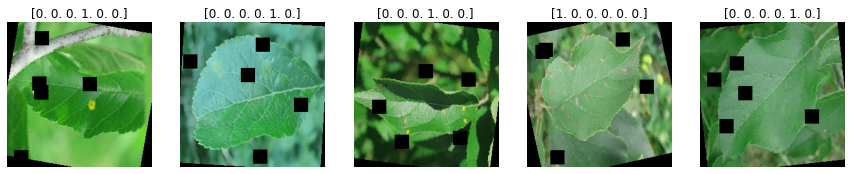

Tensor("args_0:0", shape=(), dtype=string)
Tensor("truediv:0", shape=(224, 224, 3), dtype=float32)
Tensor("truediv:0", shape=(224, 224, 3), dtype=float32)


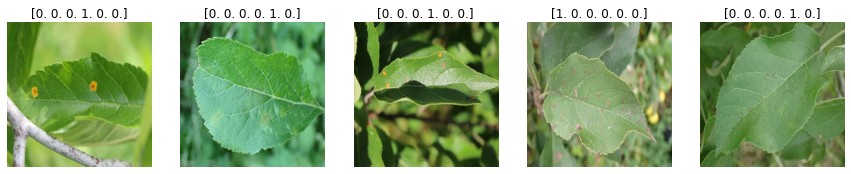

In [ ]:
def visualize_5_imgs(dataset):
    plt.figure(figsize=[15, 15])
    for i, sample in enumerate(dataset.unbatch().take(5).as_numpy_iterator()):
        plt.subplot(1, 5, i + 1)
        plt.imshow(sample[0])
        plt.title(sample[1])
        plt.axis('off')
    plt.show()

filenames = tf.io.gfile.glob(f"gs://my_colab_tpu_bucket//Datasets/PlantPathology2021/fold_0/*")[0]
dataset_aug = get_dataset(filenames, augment=True)
visualize_5_imgs(dataset_aug)
dataset_no_aug = get_dataset(filenames)
visualize_5_imgs(dataset_no_aug)

In [ ]:
folds = ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4']
def get_folds_filenames(index):
    filenames = []
    for i in index:
        files = tf.io.gfile.glob(f"{CONFIG.gsc_path}/{folds[i]}/*")
        filenames.extend(files)
    np.random.shuffle(filenames)
    return filenames


callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_f1_score', mode='max', 
        patience=CONFIG.patience_EarlyStopping, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_f1_score', mode='max',
        patience=CONFIG.patience_ReduceLR, min_lr=CONFIG.min_lr, verbose=1)
]

histories = []
scores = []
predicts = np.empty((0, len(CONFIG.classes)))
image_names = np.empty((0,))

kfold = KFold(n_splits=CONFIG.folds, shuffle=True, random_state=CONFIG.random_seed)
for i, (train_index, val_index) in enumerate(kfold.split(folds)):

    print("-"*90)
    print(" "*40,f"Fold {i+1}/{len(folds)}"," "*40)
    print("-"*90)

    with CONFIG.strategy.scope():
        model = get_model_RN50V2()
            
        model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG.lr),
            metrics=[
                tf.keras.metrics.BinaryAccuracy(name='acc'), 
                tfa.metrics.F1Score(num_classes=len(CONFIG.classes), average='macro')
            ])

    train_filenames = get_folds_filenames(train_index)
    valid_filenames = get_folds_filenames(val_index)

    train_ds = get_dataset(train_filenames, augment=True, shuffle=True, repeat=True, distribute=True, denormalize=True, resnet=True)
    valid_ds = get_dataset(valid_filenames, cache=True, denormalize=True, resnet=True)

    steps_per_epoch = count_data_items(train_filenames) // CONFIG.batch_size
    validation_steps = count_data_items(valid_filenames) // CONFIG.batch_size

    history = model.fit(
            train_ds,
            steps_per_epoch=steps_per_epoch,
            validation_data=valid_ds,
            validation_steps=validation_steps,
            callbacks=callbacks,
            epochs=CONFIG.epochs).history

    # oof
    size = count_data_items(valid_filenames)
    steps = size // CONFIG.batch_size + 1
        
    oof_dataset = get_dataset(valid_filenames, labeled=False, repeat=True, distribute=False, denormalize=True, resnet=True)
    val_predicts = model.predict(
        oof_dataset.map(lambda x, y: x), 
        steps=steps, 
        verbose=CONFIG.verbose)[:size]
    val_image_names = [x.decode() for x in oof_dataset.map(lambda x, y: y).unbatch().take(size).as_numpy_iterator()]
    
    image_names = np.concatenate((image_names, val_image_names))
    predicts = np.concatenate((predicts, val_predicts))

    # save
    model.save(f"{CONFIG.models_path}/{model.name}/model_{i+1}.h5")
    histories.append(pd.DataFrame(history))

------------------------------------------------------------------------------------------
                                         Fold 1/5                                         
------------------------------------------------------------------------------------------
Epoch 1/150
116/116 [==============================] - 1551s 13s/step - loss: 0.3264 - acc: 0.8505 - f1_score: 0.5485 - val_loss: 0.3565 - val_acc: 0.9015 - val_f1_score: 0.6219
Epoch 2/150
116/116 [==============================] - 149s 1s/step - loss: 0.1844 - acc: 0.9272 - f1_score: 0.7632 - val_loss: 0.2429 - val_acc: 0.9237 - val_f1_score: 0.7112
Epoch 3/150
116/116 [==============================] - 116s 706ms/step - loss: 0.1594 - acc: 0.9364 - f1_score: 0.7996 - val_loss: 0.1819 - val_acc: 0.9311 - val_f1_score: 0.7690
Epoch 4/150
116/116 [==============================] - 112s 649ms/step - loss: 0.1445 - acc: 0.9421 - f1_score: 0.8106 - val_loss: 0.1426 - val_acc: 0.9450 - val_f1_score: 0.8277
Epoch 5/150
116

In [ ]:
max_f1_scores = [np.max(history["val_f1_score"]) for history in histories]
np.mean(max_f1_scores)

0.8556773662567139

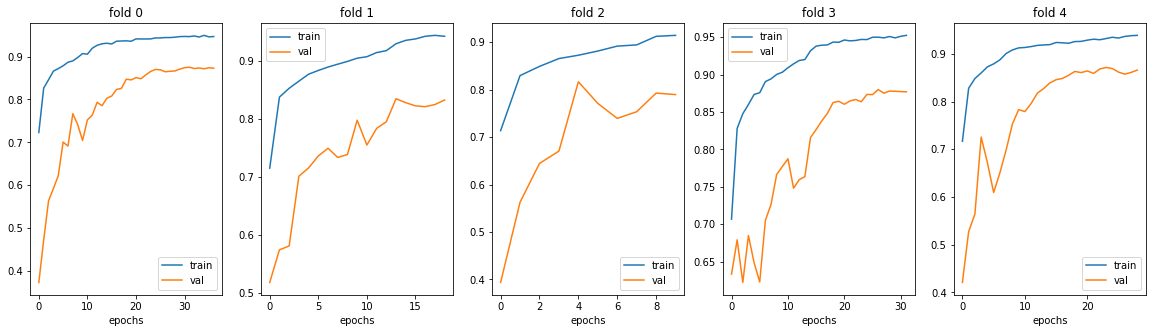

In [ ]:
figure, axes = plt.subplots(1, 5, figsize=[20, 5])

for i in range(CONFIG.folds):
    
    try:
        axes[i].plot(histories[i].loc[:, 'f1_score'], label='train')
        axes[i].plot(histories[i].loc[:, 'val_f1_score'], label='val')
        axes[i].legend()
    except IndexError:
        pass
    
    axes[i].set_title(f'fold {i}')
    axes[i].set_xlabel('epochs')
    
plt.show()

In [ ]:
predicts_df = pd.DataFrame(
    columns=CONFIG.classes, 
    data=predicts, 
    index=pd.Index(data=image_names, name='image'))

predicts_df.to_csv('oof_predicts.csv')
display(predicts_df.head())

,complex,frog_eye_leaf_spot,powdery_mildew,rust,scab,healthy
image,,,,,,
b9e5c39f99129294.jpg,9.302573e-01,1.095088e-01,0.000018,0.000582,0.310013,0.000003
d17066c7fd242d0d.jpg,9.045042e-01,9.839344e-01,0.000063,0.020387,0.142182,0.000061
c97f0593ac3974b0.jpg,0.000000e+00,1.192093e-07,0.000000,0.000000,0.000000,0.999999
e18f855851e0f8e7.jpg,8.940697e-08,2.980232e-08,0.000000,0.000001,0.999996,0.000000
d9873876fce2422c.jpg,1.378059e-04,5.646348e-04,0.000093,0.000100,0.997270,0.000338
